## Install and Import Essential libraries

In [1]:
pip install eif

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eif: filename=eif-2.0.2-cp310-cp310-linux_x86_64.whl size=322069 sha256=9445564f490ce3a184fef923fa7784fd364d814c0a9a715cc2d420bf62db3b14
  Stored in directory: /root/.cache/pip/wheels/11/9b/5e/16b95269f836d7f4bcc85f4f89d441179b1d4131a88d4587ee
Successfully built eif


In [2]:
pip install igraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 50.7 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import igraph as ig
import matplotlib.pyplot as plt
import numpy as np
import random as rn
import eif as iso
import copy
import seaborn as sb
import pandas as pd
sb.set_style(style="whitegrid")
sb.set_color_codes()
ig.__version__

'0.10.5'

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

## Dataset

Natural gas prices:
Time series of major Natural Gas Prices including US Henry Hub. Data comes from U.S. Energy Information Administration EIA Data Dataset contains Monthly and Daily prices of Natural gas, starting from January 1997 to current year. Prices are in nominal dollars.

In [6]:
path="/content/drive/MyDrive/monthly_csv.csv"

In [7]:
data=pd.read_csv(path)

In [8]:
data.head(10)

,Month,Price
0,1997-01,3.45
1,1997-02,2.15
2,1997-03,1.89
3,1997-04,2.03
4,1997-05,2.25
5,1997-06,2.20
6,1997-07,2.19
7,1997-08,2.49
8,1997-09,2.88
9,1997-10,3.07


## Exploratory Data Analysis

In [9]:
data["Month"]=pd.to_datetime(data["Month"])

In [10]:
data = data.rename(columns={'Month': 'Date'})

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284 entries, 0 to 283
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    284 non-null    datetime64[ns]
 1   Price   284 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.6 KB


In [12]:
data.describe()

,Price
count,284.000000
mean,4.207782
std,2.183396
min,1.630000
25%,2.660000
50%,3.560000
75%,5.327500
max,13.420000


In [13]:
data.columns

Index(['Date', 'Price'], dtype='object')

In [14]:
def plot(df):
  df=data.copy()
  df.set_index('Date', inplace=True)
  # Plot the time series
  plt.figure(figsize=(12, 6))
  plt.plot(df.index, df['Price'])
  plt.title('Price over Time')
  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.grid(True)
  plt.show()

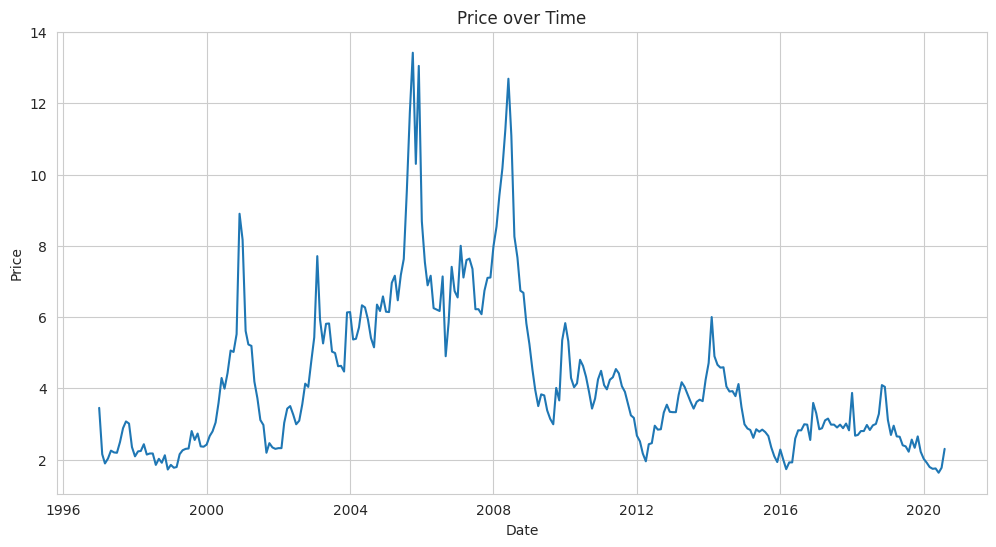

In [15]:
plot(data)

In [16]:
data.columns

Index(['Date', 'Price'], dtype='object')

## Comparing performance between The iForest and the EIF

In [17]:
features=np.zeros((284,2))

In [18]:
Price_col= data["Price"].values
index_col=np.array(data.index)
features[:,1]=Price_col
features[:,0]=index_col

In [19]:
features.shape

(284, 2)

In [20]:
features.dtype

dtype('float64')

In [21]:
F0=iso.iForest(features, ntrees=500, sample_size=256, ExtensionLevel=0)#iForest
F1=iso.iForest(features, ntrees=500, sample_size=256, ExtensionLevel=1)#EIF

In [22]:
anomaly_scores_0=F0.compute_paths(X_in=features)# anomaly score created by iForest
anomaly_scores_1=F1.compute_paths(X_in=features)# anomaly score created by EIF

In [30]:
#To set the threshold I used the Median Absolute Deviation (MAD) method
def compute_mad(scores):
    median = np.median(scores)
    abs_deviations = np.abs(scores - median)
    mad = np.median(abs_deviations)
    return mad

def set_threshold(scores, scaling_factor=2):
    median = np.median(scores)
    mad = compute_mad(scores)
    threshold = median + (scaling_factor * mad)
    return threshold
threshold0=set_threshold(anomaly_scores_0)
threshold1=set_threshold(anomaly_scores_1)

In [31]:
x,y=features[:,0],features[:,1]
anomaly_indices_0 = np.where(anomaly_scores_0 >threshold0)[0]
anomaly_indices_1 = np.where(anomaly_scores_1 >threshold1)[0]


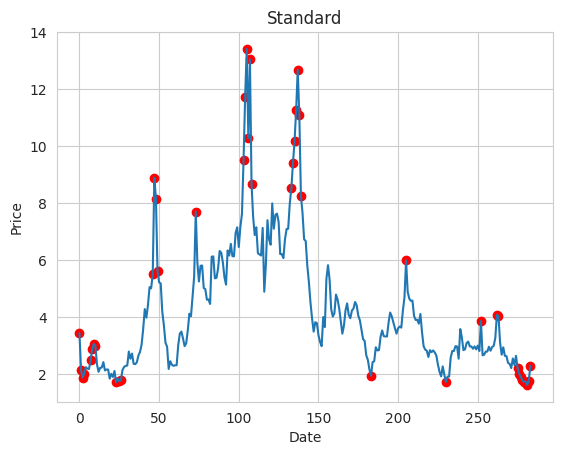

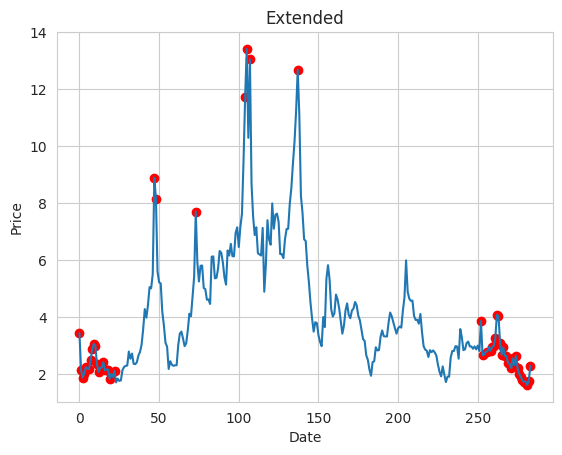

In [32]:
fig1 = plt.figure()
plt.plot(x, y)
plt.scatter(x[anomaly_indices_0], y[anomaly_indices_0], color='red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Standard')
plt.show()
fig2= plt.figure()
plt.plot(x, y)
plt.scatter(x[anomaly_indices_1], y[anomaly_indices_1], color='red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Extended')
plt.show()




### Score Maps

In [26]:
def getDepth(x, root, d):
    n = root.n
    p = root.p
    if root.ntype == 'exNode':
        return d
    else:
        if (x-p).dot(n) < 0:
            return getDepth(x,root.left,d+1)
        else:
            return getDepth(x,root.right,d+1)

def getVals(forest,x,sorted=True):
    theta = np.linspace(0,2*np.pi, forest.ntrees)
    r = []
    for i in range(forest.ntrees):
        temp = forest.compute_paths_single_tree(np.array([x]),i)
        r.append(temp[0])
    if sorted:
        r = np.sort(np.array(r))
    return r, theta

In [27]:
x,y=features[:,0],features[:,1]

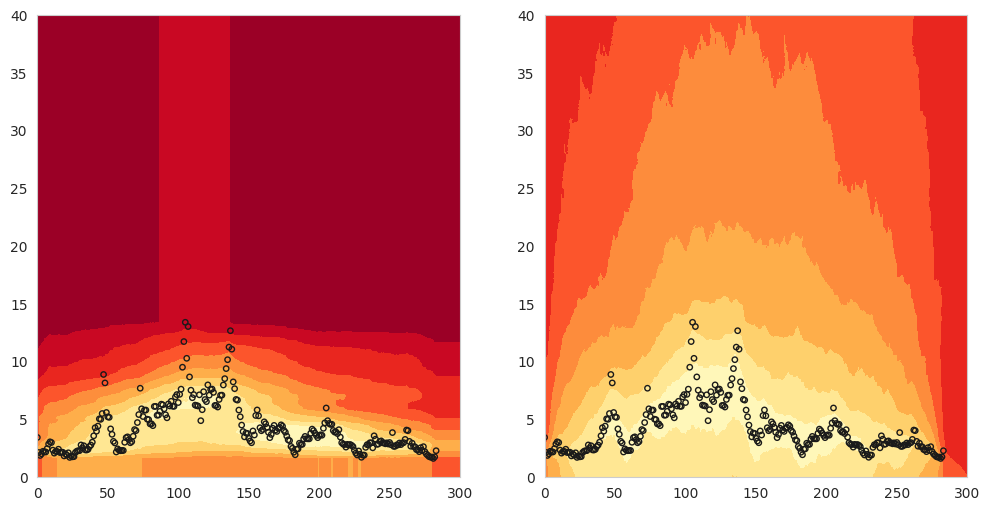

In [28]:
xx, yy = np.meshgrid(np.linspace(0, 300, 300), np.linspace(0, 40, 300))

S0 = F0.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()])
S0 = S0.reshape(xx.shape)

S1 = F1.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()])
S1 = S1.reshape(xx.shape)
f = plt.figure(figsize=(12,6))

ax1 = f.add_subplot(121)
levels = np.linspace(np.min(S0),np.max(S0),10)
CS = ax1.contourf(xx, yy, S0, levels, cmap=plt.cm.YlOrRd)
plt.scatter(x,y,s=15,c='None',edgecolor='k')


ax2 = f.add_subplot(122)
levels = np.linspace(np.min(S1),np.max(S0),10)
CS = ax2.contourf(xx, yy, S1, levels, cmap=plt.cm.YlOrRd)
plt.scatter(x,y,s=15,c='None',edgecolor='k')


plt.show()

### Forest visulization

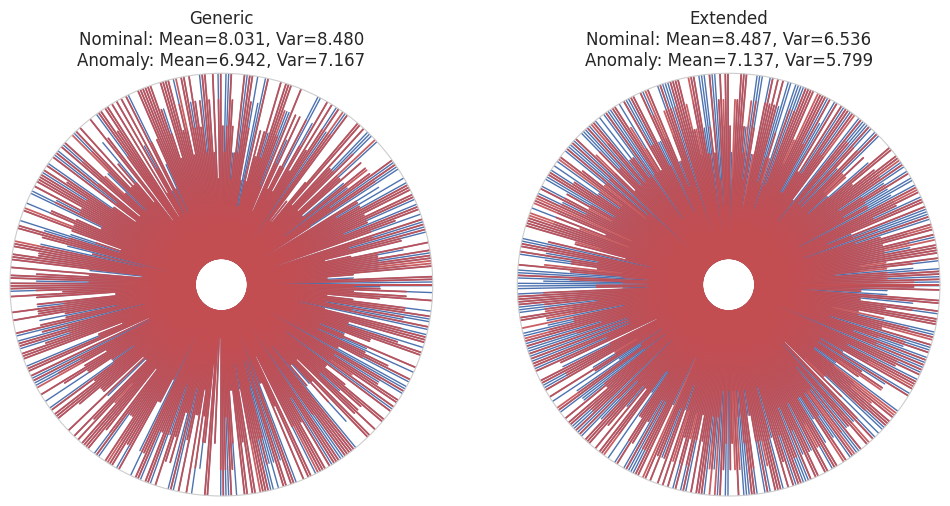

In [29]:
Sorted=False
fig = plt.figure(figsize=(12,6))
ax1 = plt.subplot(121, projection='polar')
rn, thetan = getVals(F0,np.array([10.,0.]),sorted=Sorted)
for j in range(len(rn)):
    ax1.plot([thetan[j],thetan[j]], [1,rn[j]], color='b',alpha=1,lw=1)

ra, thetaa = getVals(F0,np.array([-5.,-3.]),sorted=Sorted)
for j in range(len(ra)):
    ax1.plot([thetaa[j],thetaa[j]], [1,ra[j]], color='r',alpha=0.9,lw=1.3)

ax1.set_title("Generic\nNominal: Mean={0:.3f}, Var={1:.3f}\nAnomaly: Mean={2:.3f}, Var={3:.3f}".format(np.mean(rn),np.var(rn),np.mean(ra),np.var(ra)))

ax1.set_xticklabels([])
ax1.set_xlabel("Anomaly")
ax1.set_ylim(0,F0.limit)

ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)
#ax1.text(0,F0.limit+0.4,"800 Trees, full depth")

ax2 = plt.subplot(122, projection='polar')
rn, thetan = getVals(F1,np.array([10.,0.]),sorted=Sorted)
for j in range(len(rn)):
    ax2.plot([thetan[j],thetan[j]], [1,rn[j]], color='b',alpha=1,lw=1)

ra, thetaa = getVals(F1,np.array([-5.,-3.]),sorted=Sorted)
for j in range(len(ra)):
    ax2.plot([thetaa[j],thetaa[j]], [1,ra[j]], color='r',alpha=0.9,lw=1.3)


ax2.set_title("Extended\nNominal: Mean={0:.3f}, Var={1:.3f}\nAnomaly: Mean={2:.3f}, Var={3:.3f}".format(np.mean(rn),np.var(rn),np.mean(ra),np.var(ra)))

ax2.set_xticklabels([])
ax2.set_xlabel("Anomaly")
ax2.set_ylim(0,F0.limit)

ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)